In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss

# SPY

In [41]:
spy = pd.read_pickle('SPY.pkl')

<Axes: xlabel='LABEL', ylabel='Count'>

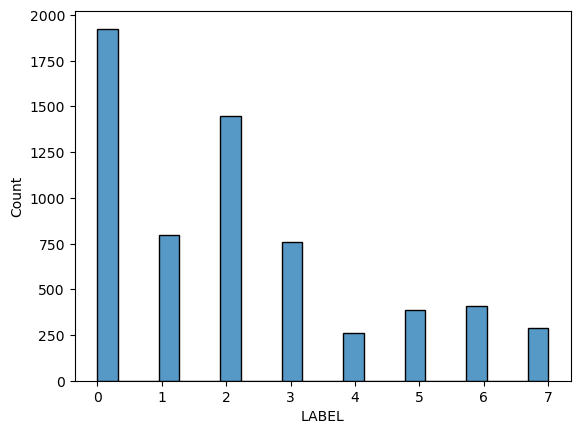

In [42]:
sns.histplot(spy['LABEL'])

## Creating Lag Features of Last 20 Days

In [43]:
def lag_xgb(spy):
    lag_features = []
    for i in range(1, 21):
        lag_features.append(spy.shift(i).add_suffix(f'_t{i}'))

    spy = pd.concat([spy] + lag_features, axis=1).dropna().reset_index(drop = True)
    return spy

In [44]:
spy = lag_xgb(spy)

## SPY XGBoost Multiclass

In [58]:
def plot_training_curves(model, metric):
    results = model.evals_result_
    
    # Plot training and validation curves
    plt.figure(figsize=(12, 6))
    # Plot training performance
    plt.plot(results['validation_0'][metric], label='Training '+metric)
    plt.plot(results['validation_1'][metric], label='Validation '+metric)
    plt.title('Training and Validation Learning Curves')
    plt.xlabel('Boosting Round')
    plt.ylabel(metric)
    plt.legend()
    
def predict(X_train, X_val, X_test, model):
    test_prob = model.predict_proba(X_test)
    test_pred = np.argmax(test_prob, axis=1)
    train_prob = model.predict_proba(X_train)
    train_pred = np.argmax(train_prob, axis=1)
    val_prob = model.predict_proba(X_val)
    val_pred = np.argmax(val_prob, axis=1)
    return test_pred, test_prob,train_pred,train_prob, val_pred, val_prob

def cfm_metrics(test_cfm):
    positive = np.sum(np.diag(test_cfm))
    total_samples = np.sum(test_cfm)
    negative = total_samples - positive
    return positive, negative
def classification_results(y_test, y_train, y_val, model,xgb_train_prob, xgb_val_prob, xgb_test_prob,xgb_test_pred, xgb_val_pred, xgb_train_pred, metric):
  test_cfm = confusion_matrix(y_test,xgb_test_pred)
  val_cfm = confusion_matrix(y_val,xgb_val_pred)
  train_cfm = confusion_matrix(y_train,xgb_train_pred)

  train_cfm_summary = cfm_metrics(train_cfm)
  test_cfm_summary = cfm_metrics(test_cfm)
  val_cfm_summary = cfm_metrics(val_cfm)

  train_val_test =pd.DataFrame([[train_cfm_summary[0]/(train_cfm_summary[1]+train_cfm_summary[0]),log_loss(y_train, xgb_train_prob),roc_auc_score(y_train, xgb_train_prob, multi_class='ovr')],
                                  [val_cfm_summary[0]/(val_cfm_summary[1]+val_cfm_summary[0]),log_loss(y_val, xgb_val_prob),roc_auc_score(y_val, xgb_val_prob, multi_class='ovr')],
                                  [test_cfm_summary[0]/(test_cfm_summary[1]+test_cfm_summary[0]),log_loss(y_test, xgb_test_prob),roc_auc_score(y_test, xgb_test_prob, multi_class='ovr')]], 
                              columns = ['Accuracy', 'Log Loss','ROC_AUC'], index = ['Train', 'Validation', 'Test']).T
  print(train_val_test)
  plot_training_curves(model,metric)
  print('Training: ')
  print(classification_report(y_train, xgb_train_pred))
  print('Validation: ')
  print(classification_report(y_val, xgb_val_pred))
  print('Testing: ')
  print(classification_report(y_test, xgb_test_pred))

             Train  Validation      Test
Accuracy  0.360229    0.313767  0.352878
Log Loss  1.843422    1.886890  1.853727
ROC_AUC   0.686503    0.613245  0.625416
Training: 
              precision    recall  f1-score   support

           0       0.35      0.87      0.50      1344
           1       0.00      0.00      0.00       549
           2       0.39      0.38      0.39      1034
           3       0.67      0.02      0.03       517
           4       0.00      0.00      0.00       180
           5       0.00      0.00      0.00       262
           6       0.80      0.01      0.03       288
           7       0.00      0.00      0.00       201

    accuracy                           0.36      4375
   macro avg       0.28      0.16      0.12      4375
weighted avg       0.33      0.36      0.25      4375

Validation: 
              precision    recall  f1-score   support

           0       0.31      0.86      0.45       257
           1       0.00      0.00      0.00       13

/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.1

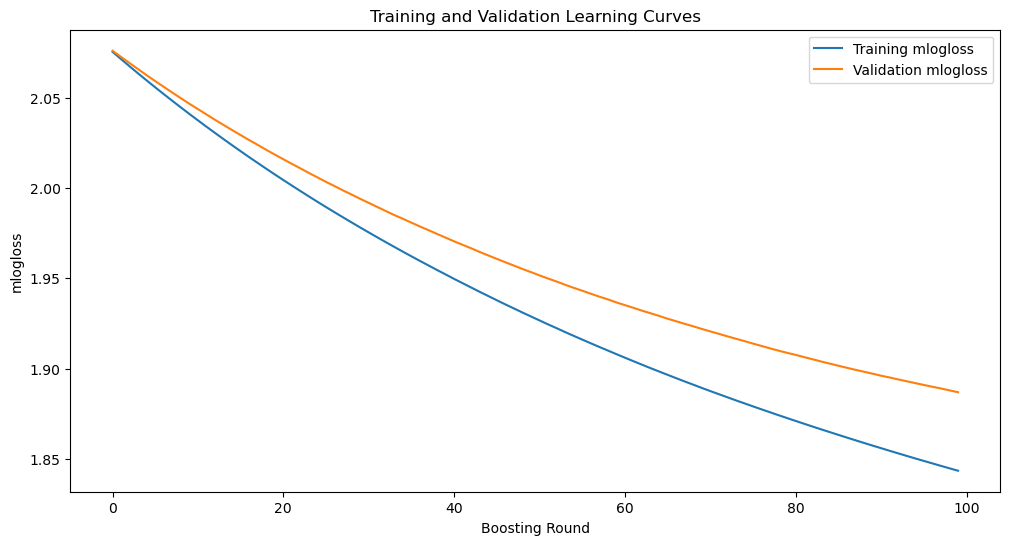

In [ ]:
X = spy.drop(['LABEL'], axis=1).values
y = spy['LABEL'].values

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=1)

# Train an XGBoost multi-class classifier
xgb_spy = XGBClassifier(objective='multi:softmax', num_class=8, n_estimators=100,
                            learning_rate = .01,
                            reg_alpha = .5, max_depth = 2,
                            random_state=1, eval_metric = 'mlogloss') #early_stopping_rounds = 50,
xgb_spy.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), # training set included for plotting training curves
                    (X_val, y_val)], verbose = False)
xgb_test_pred, xgb_test_prob, xgb_train_pred, xgb_train_prob, xgb_val_pred, xgb_val_prob = predict(X_train, X_val, X_test, xgb_spy)
classification_results(y_test, y_train, y_val, xgb_spy,xgb_train_prob, xgb_val_prob, xgb_test_prob,xgb_test_pred, xgb_val_pred, xgb_train_pred,'mlogloss')

# US Equities

<Axes: xlabel='LABEL', ylabel='Count'>

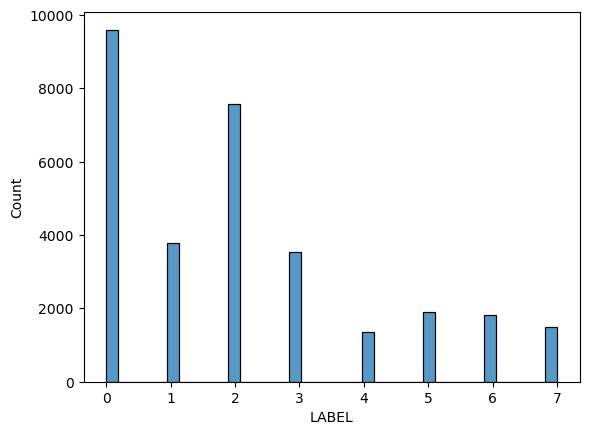

In [ ]:
us = pd.read_pickle('US_EQUITY.pkl')
sns.histplot(us['LABEL'])

In [ ]:
us = lag_xgb(us)

             Train  Validation      Test
Accuracy  0.358553    0.353308  0.363324
Log Loss  1.851767    1.860110  1.848658
ROC_AUC   0.646979    0.630771  0.626712
Training: 
              precision    recall  f1-score   support

           0       0.36      0.84      0.50      6670
           1       0.00      0.00      0.00      2645
           2       0.36      0.41      0.38      5318
           3       0.00      0.00      0.00      2514
           4       0.00      0.00      0.00       925
           5       0.00      0.00      0.00      1305
           6       0.00      0.00      0.00      1285
           7       0.00      0.00      0.00      1067

    accuracy                           0.36     21729
   macro avg       0.09      0.16      0.11     21729
weighted avg       0.20      0.36      0.25     21729

Validation: 
              precision    recall  f1-score   support

           0       0.36      0.83      0.50      1448
           1       0.00      0.00      0.00       56

/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.1

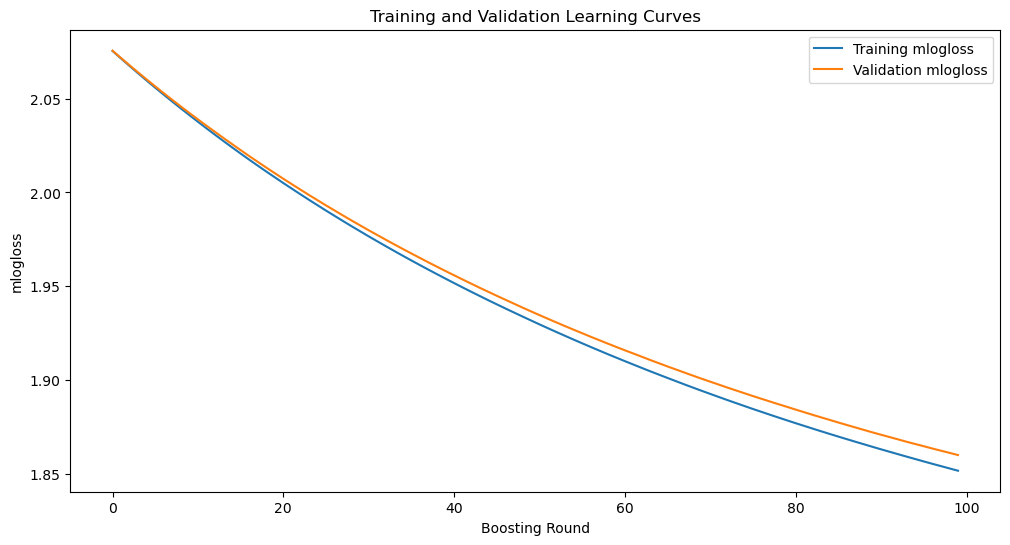

In [66]:
X = us.drop(['LABEL'], axis=1).values
y = us['LABEL'].values

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=1)

# Train an XGBoost multi-class classifier
xgb_us = XGBClassifier(objective='multi:softmax', num_class=8, n_estimators=100,
                            learning_rate = .01,
                            reg_alpha = .5, max_depth = 2,
                            random_state=1, eval_metric = 'mlogloss') #early_stopping_rounds = 50,
xgb_us.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), # training set included for plotting training curves
                    (X_val, y_val)], verbose = False)
xgb_test_pred, xgb_test_prob, xgb_train_pred, xgb_train_prob, xgb_val_pred, xgb_val_prob = predict(X_train, X_val, X_test, xgb_us)
classification_results(y_test, y_train, y_val, xgb_us,xgb_train_prob, xgb_val_prob, xgb_test_prob,xgb_test_pred, xgb_val_pred, xgb_train_pred,'mlogloss')

# International Equities

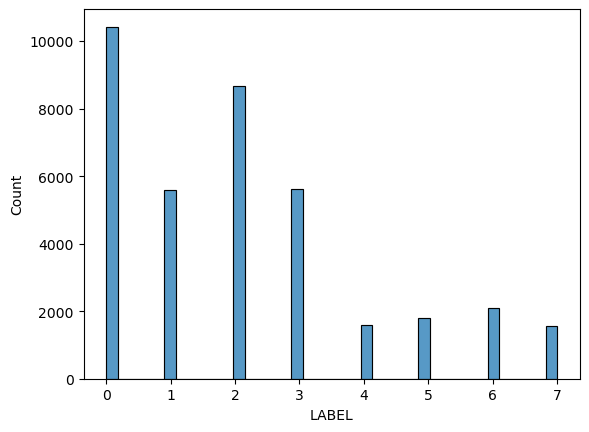

In [67]:
intl = pd.read_pickle('INTL_EQUITY.pkl')
sns.histplot(intl['LABEL'])
intl = lag_xgb(intl)

             Train  Validation      Test
Accuracy  0.312965    0.305382  0.303182
Log Loss  1.894625    1.897409  1.903059
ROC_AUC   0.600392    0.580778  0.576711
Training: 
              precision    recall  f1-score   support

           0       0.33      0.68      0.44      7310
           1       0.00      0.00      0.00      3872
           2       0.29      0.52      0.37      6067
           3       0.00      0.00      0.00      3917
           4       0.00      0.00      0.00      1093
           5       0.00      0.00      0.00      1262
           6       0.40      0.01      0.02      1475
           7       0.00      0.00      0.00      1106

    accuracy                           0.31     26102
   macro avg       0.13      0.15      0.11     26102
weighted avg       0.18      0.31      0.21     26102

Validation: 
              precision    recall  f1-score   support

           0       0.33      0.69      0.44      1563
           1       0.00      0.00      0.00       84

/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.1

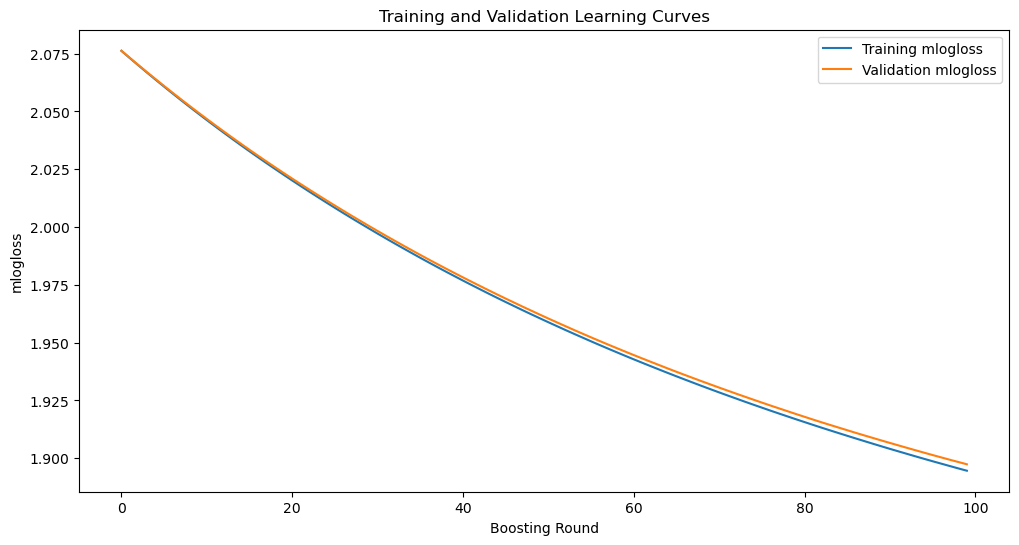

In [68]:
X = intl.drop(['LABEL'], axis=1).values
y = intl['LABEL'].values

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=1)

# Train an XGBoost multi-class classifier
xgb_intl = XGBClassifier(objective='multi:softmax', num_class=8, n_estimators=100,
                            learning_rate = .01,
                            reg_alpha = .5, max_depth = 2,
                            random_state=1, eval_metric = 'mlogloss') #early_stopping_rounds = 50,
xgb_intl.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), # training set included for plotting training curves
                    (X_val, y_val)], verbose = False)
xgb_test_pred, xgb_test_prob, xgb_train_pred, xgb_train_prob, xgb_val_pred, xgb_val_prob = predict(X_train, X_val, X_test, xgb_intl)
classification_results(y_test, y_train, y_val, xgb_intl,xgb_train_prob, xgb_val_prob, xgb_test_prob,xgb_test_pred, xgb_val_pred, xgb_train_pred,'mlogloss')

# Precious Metals

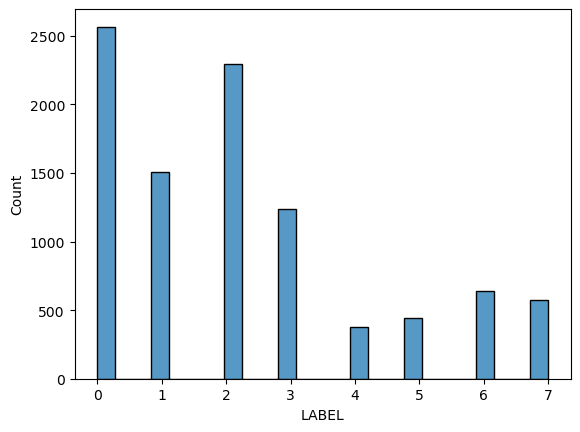

In [69]:
pm = pd.read_pickle('PREC_METAL.pkl')
sns.histplot(pm['LABEL'])
pm = lag_xgb(pm)

             Train  Validation      Test
Accuracy  0.319424    0.314622  0.284823
Log Loss  1.902159    1.905746  1.921757
ROC_AUC   0.658309    0.576062  0.572576
Training: 
              precision    recall  f1-score   support

           0       0.32      0.75      0.45      1766
           1       0.49      0.03      0.06      1057
           2       0.31      0.49      0.38      1601
           3       0.00      0.00      0.00       866
           4       0.67      0.01      0.03       269
           5       0.00      0.00      0.00       316
           6       0.56      0.01      0.02       454
           7       0.00      0.00      0.00       405

    accuracy                           0.32      6734
   macro avg       0.29      0.16      0.12      6734
weighted avg       0.30      0.32      0.22      6734

Validation: 
              precision    recall  f1-score   support

           0       0.33      0.70      0.45       422
           1       0.07      0.00      0.01       21

/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.1

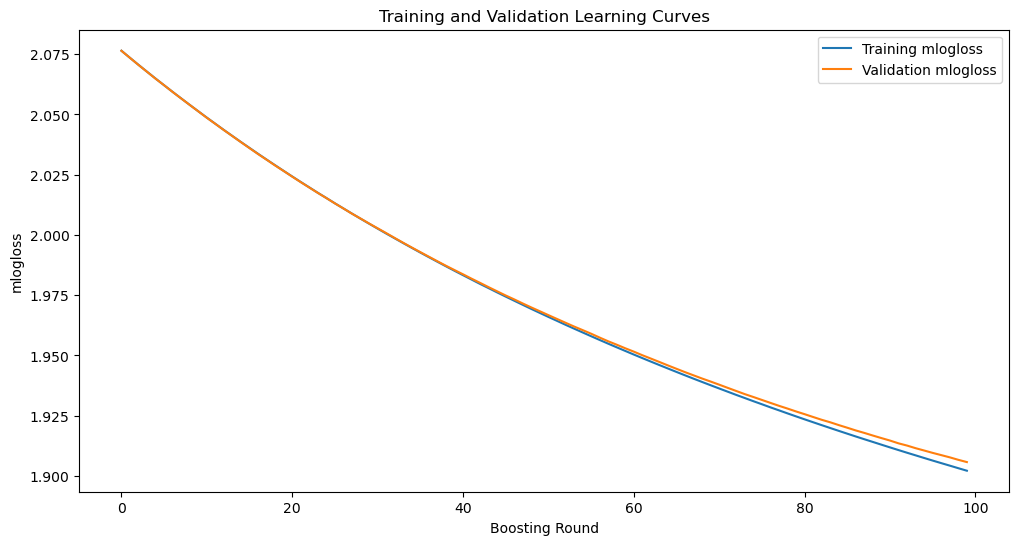

In [70]:
X = pm.drop(['LABEL'], axis=1).values
y = pm['LABEL'].values

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=1)

# Train an XGBoost multi-class classifier
xgb_pm = XGBClassifier(objective='multi:softmax', num_class=8, n_estimators=100,
                            learning_rate = .01,
                            reg_alpha = .5, max_depth = 2,
                            random_state=1, eval_metric = 'mlogloss') #early_stopping_rounds = 50,
xgb_pm.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), # training set included for plotting training curves
                    (X_val, y_val)], verbose = False)
xgb_test_pred, xgb_test_prob, xgb_train_pred, xgb_train_prob, xgb_val_pred, xgb_val_prob = predict(X_train, X_val, X_test, xgb_pm)
classification_results(y_test, y_train, y_val, xgb_pm,xgb_train_prob, xgb_val_prob, xgb_test_prob,xgb_test_pred, xgb_val_pred, xgb_train_pred,'mlogloss')

# Commodities

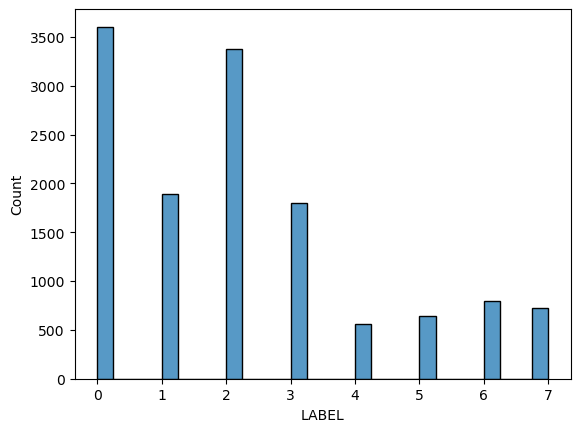

In [71]:
comm = pd.read_pickle('COMM.pkl')
sns.histplot(comm['LABEL'])
comm = lag_xgb(comm)

             Train  Validation      Test
Accuracy  0.320162    0.320877  0.319382
Log Loss  1.886946    1.909486  1.897613
ROC_AUC   0.619215    0.581302  0.577945
Training: 
              precision    recall  f1-score   support

           0       0.32      0.61      0.42      2532
           1       0.00      0.00      0.00      1320
           2       0.31      0.61      0.41      2373
           3       0.00      0.00      0.00      1274
           4       1.00      0.01      0.02       365
           5       0.00      0.00      0.00       453
           6       1.00      0.00      0.01       537
           7       0.47      0.03      0.05       510

    accuracy                           0.32      9364
   macro avg       0.39      0.16      0.11      9364
weighted avg       0.29      0.32      0.22      9364

Validation: 
              precision    recall  f1-score   support

           0       0.31      0.63      0.41       500
           1       0.00      0.00      0.00       29

/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.1

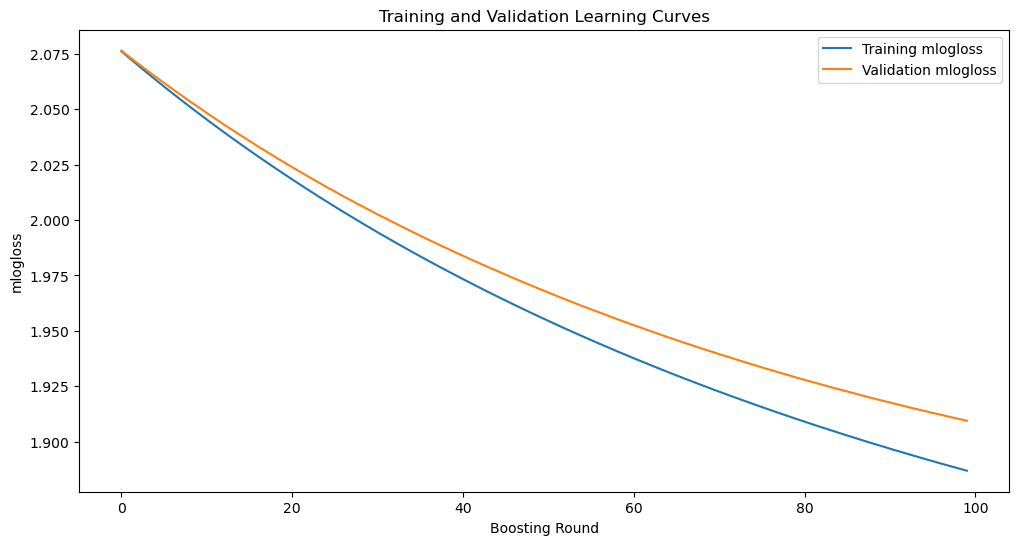

In [72]:
X = comm.drop(['LABEL'], axis=1).values
y = comm['LABEL'].values

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=1)

# Train an XGBoost multi-class classifier
xgb_comm = XGBClassifier(objective='multi:softmax', num_class=8, n_estimators=100,
                            learning_rate = .01,
                            reg_alpha = .5, max_depth = 2,
                            random_state=1, eval_metric = 'mlogloss') #early_stopping_rounds = 50,
xgb_comm.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), # training set included for plotting training curves
                    (X_val, y_val)], verbose = False)
xgb_test_pred, xgb_test_prob, xgb_train_pred, xgb_train_prob, xgb_val_pred, xgb_val_prob = predict(X_train, X_val, X_test, xgb_comm)
classification_results(y_test, y_train, y_val, xgb_comm,xgb_train_prob, xgb_val_prob, xgb_test_prob,xgb_test_pred, xgb_val_pred, xgb_train_pred,'mlogloss')